# Agriculture in Niger

## Request

Using NASA remote sensing data, analyze agricultural productivity trends in cropland areas.  

For known commercial farms (static extent from LGRIP), analyze crop cycle/productivity over past 5 years (tbc by CO). Figures updated annually. 

For 2023 (season is June through November), identify total area of farms that have seen relatively consistent historic plantings but do not have observed plantings for 2023 growing season. Method for seasonal updates to be developed at a minimum after 2024 season ends (pending data quality and availability). 

## Datasets

### Cropland Extent

We examined different cropland masks for the region, and decided that the layer produced by [Digital Earth Africa in 2021](https://docs.digitalearthafrica.org/en/latest/data_specs/Cropland_extent_specs.html) best represents the recent state of cropland in the Niger. The map has a resultion of 10 meters and was built with Sentinel-2 images fom 2019. They used a Random Forest Classification with ~25K training samples for the continent, achieving an 87.9% accuracy for the Sahel region.

Below is an interactive map that visualizes the mask we used, and a comparison with another global layer by [USGS (LGRIP30)](https://lpdaac.usgs.gov/products/lgrip30v001/).

In [2]:
import ee
import json, os
from dotenv import load_dotenv
load_dotenv()
ee_creds = {
    'type': 'service_account',
    'project_id': os.getenv('PROJECT_ID'),
    'private_key_id': os.getenv('PRIVATE_KEY_ID'),
    'private_key': os.getenv('PRIVATE_KEY'),
    'client_email': os.getenv('CLIENT_EMAIL'),
    'client_id': os.getenv('CLIENT_ID'),
    'auth_uri': 'https://accounts.google.com/o/oauth2/auth',
    'token_uri': 'https://oauth2.googleapis.com/token',
    'auth_provider_x509_cert_url': 'https://www.googleapis.com/oauth2/v1/certs',
    'client_x509_cert_url': os.getenv('CLIENT_X509_CERT_URL')
}
service_account = 'notebook@food-security-391017.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, key_data=json.dumps(ee_creds))
ee.Initialize(credentials)

In [3]:
from geemap.foliumap import Map
import requests
import geopandas as gpd
from geemap.conversion import *
from geemap import colormaps

# Admin Data
adm = 'ADM0'
iso3 = 'NER'
release_type = 'gbOpen'
geo_url = f'https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/'
try:
  res = requests.get(geo_url).json()
  adm0_ner = gpd.read_file(res['gjDownloadURL'])
  # adm0_ner.to_file('../../data/adm0_ner.geojson', driver='GeoJSON')
except:
  adm0_ner = gpd.read_file('../../data/adm0_ner.geojson')
  
one = adm0_ner.iloc[[0]]
centx, centy = one.centroid.x.iloc[0], one.centroid.y.iloc[0]
aoi = gdf_to_ee(adm0_ner)

# Crop Masks
lgrip30 = ee.ImageCollection("projects/sat-io/open-datasets/GFSAD/LGRIP30").mosaic()
crop_data = lgrip30.select('b1').rename('crop').clip(aoi)
crop_data_viz = crop_data.mask(crop_data.gt(1))

dea = ee.ImageCollection("projects/sat-io/open-datasets/DEAF/CROPLAND-EXTENT/mask").mosaic()
crop_data_dea = dea.select('b1').rename('crop').clip(aoi)
crop_data_viz_dea = crop_data_dea.mask(crop_data_dea.gt(0))

# Viz
crop_vis = {
    'min': 2,
    'max': 3,
    'palette': ['#cc0000', '#529400'],
    'opacity': 0.75
}
crop_vis2 = {
    'min': 0,
    'max': 1,
    'palette': ['#529400'],
    'opacity': 0.75
}
pal = colormaps.get_palette('Greens', 10) # Greens BrBG
adm_vis = {
    'color': '000000',
    'width': 1,
    'opacity': 0.25
}

m = Map(center=[centy, centx], zoom=6) # basemap='Esri.WorldImagery'
m.add_basemap('Esri.WorldImagery')
m.addLayer(crop_data_viz, crop_vis, 'Crop Mask (LGRIP30)') # Green is Rainfed, Red is Irrigated
m.addLayer(crop_data_viz_dea, crop_vis2, 'Crop Mask (Digital Earth Africa)') # Green is Rainfed, Red is Irrigated
m.addLayer(aoi, adm_vis, 'Country Boundary')
m.addLayerControl()
m

C:\Users\WB514197\AppData\Local\Temp\ipykernel_28172\3742192984.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centx, centy = one.centroid.x.iloc[0], one.centroid.y.iloc[0]


### Crop Area by Region

In [4]:
import pandas as pd
import json
import ast
df = pd.read_csv('../../data/adm1_crop_count.csv')

def load_dict(input_str):
    input_str = input_str.replace('null', "'null'")
    input_str = input_str.replace('=', ':')
    result_dict = ast.literal_eval(input_str)
    return(result_dict)

df.loc[:, "histogram"] = df.apply(lambda x: load_dict(x['histogram']), axis=1)

bool_dict = {
    0:'non_crop',
    1:'crop',
}
histograms = df['histogram']
histograms_dfs = [pd.DataFrame(index=[idx], data=hist_dict) for idx, hist_dict in histograms.items()]
histogram_df = pd.concat(histograms_dfs, axis=0).fillna(0)
histogram_df.rename(columns=bool_dict, inplace=True)

df = df.join(histogram_df)
df = df.sort_values(by='crop', ascending=False)
df.loc[:, "Crop Area ha."] = ((df['crop'] * 100) / 10000).apply(lambda x: f'{x:,.0f}')
df.loc[:, "Crop Area Share"] = (df['crop'] / (df['crop'] + df['non_crop'])).apply(lambda x: f'{x:.2%}')
df.rename(columns={'ADM1_FR':'Region'}, inplace=True)
df[['Region', 'Crop Area ha.', 'Crop Area Share']].reset_index(drop=True)

,Region,Crop Area ha.,Crop Area Share
0,Maradi,"2,519,230",61.74%
1,Zinder,"2,190,192",14.35%
2,Dosso,"1,236,565",38.27%
3,Tillabéri,"1,087,188",11.68%
4,Tahoua,"956,003",8.54%
5,Diffa,"122,461",0.79%
6,Agadez,"55,050",0.08%
7,Niamey,"4,843",8.71%


### MODIS
We utilize Google Earth Engine to access the Enhanced Vegetation Index (EVI) band from the [MODIS satellite](https://modis.gsfc.nasa.gov/about/). By combining data from [Terra](https://lpdaac.usgs.gov/products/mod13q1v061/) and [Aqua](https://lpdaac.usgs.gov/products/myd13q1v061/), we obtain a map of EVI at 250 meters resolution every 8-days from 2001 to 2024. 

The enhanced vegetation index (EVI) is an 'optimized' vegetation index designed to enhance the vegetation signal with improved vegetation monitoring through a de-coupling of the canopy background signal and a reduction in atmosphere influences.

We apply the necessary data masking steps:
1. Mask out bad quality data (shadows/clouds)
2. Mask out non-crop areas using the Digital Earth Africa crop layer.

Below is an interactive map of EVI data for one timestep (2023-09-01)

In [5]:
# MODIS
start_period = ee.Date('2001-01-01')
end_period = ee.Date('2024-01-01')
terra = ee.ImageCollection('MODIS/061/MOD13Q1') \
    .select(['EVI','SummaryQA','DetailedQA'])   \
    .filterDate(start_period, end_period)
aqua = ee.ImageCollection('MODIS/061/MYD13Q1')  \
    .select(['EVI','SummaryQA','DetailedQA'])   \
    .filterDate(start_period, end_period)
modis = terra.select('EVI').merge(aqua.select('EVI'))
modis = modis.sort("system:time_start")
def bitwiseExtract(value, fromBit, toBit=None):
  if (toBit == None):
    toBit = fromBit
  maskSize = ee.Number(1).add(toBit).subtract(fromBit)
  mask = ee.Number(1).leftShift(maskSize).subtract(1)
  return value.rightShift(fromBit).bitwiseAnd(mask)
# Applying the SummaryQA  and DetailedQA
def modisQA_mask(image):
  sqa = image.select('SummaryQA')
  dqa = image.select('DetailedQA')
  viQualityFlagsS = bitwiseExtract(sqa, 0, 1)
  viQualityFlagsD = bitwiseExtract(dqa, 0, 1)
  # viUsefulnessFlagsD = bitwiseExtract(dqa, 2, 5)
  viSnowIceFlagsD = bitwiseExtract(dqa, 14)
  viShadowFlagsD = bitwiseExtract(dqa, 15)
  # Good data, use with confidence
  mask = viQualityFlagsS.eq(0)  \
    .And(viQualityFlagsD.eq(0)) \
    .And(viQualityFlagsS.eq(1)) \
    .And(viQualityFlagsD.eq(1)) \
    .And(viSnowIceFlagsD).eq(0); 
    # .And(viShadowFlagsD).eq(0); # No shadow
  return image.updateMask(mask)
mod13q1_QC = terra.map(modisQA_mask)
myd13q1_QC = aqua.map(modisQA_mask)
mxd13q1_cleaned = mod13q1_QC.select('EVI').merge(myd13q1_QC.select('EVI'))
mxd13q1_cleaned_sorted = mxd13q1_cleaned.sort("system:time_start")

scale_factor=0.0001
crop_data2 = dea.select('b1').gt(0).rename('crop')
def cropmask(img):
  return img.updateMask(crop_data2).clip(aoi) #.multiply(scale_factor) # unmask(-1)
mxd13q1 = mxd13q1_cleaned_sorted.map(cropmask)
img = mxd13q1.filterDate('2023-09-01', '2023-10-01').select('EVI').first().multiply(scale_factor)

# Viz
pal = colormaps.get_palette('Greens', 10) # Greens BrBG
evi_vis = {
    'min': 0.1,
    'max': 0.4,
    'palette': pal
}
adm_vis = {
    'color': '000000',
    'width': 1,
    'opacity': 0.25
}

m = Map(center=[centy, centx], zoom=6) # basemap='Esri.WorldImagery'
m.add_basemap('Esri.WorldImagery')
m.addLayer(aoi, adm_vis, 'Country Boundary')
m.addLayer(img, evi_vis, 'EVI One Time Step (2023-09-01)')
m.add_colorbar(evi_vis, label="Enhanced Vegetation Index (EVI)")
m.addLayerControl()
m

## Methodology

### Crop Seasonality
Using this time series dataset of EVI images, we apply several pre-processing steps to extract critical phenological parameters: start of season (SOS), middle of season (MOS), end of season (EOS), length of season (LOS), etc. This workflow is heavily inspired by the [TIMESAT](https://web.nateko.lu.se/timesat/timesat.asp) software, although in this implementation we use the [Phenolopy](https://github.com/frontiersi/phenolopy/tree/main) open-source package.  

**Pre-processing steps**  
1. Remove outliers from dataset on per-pixel basis using median method: outlier if median from a moving window < or > standard deviation of time-series times 2.
2. Interpolate missing values linearly
3. Smooth data on per-pixel basis (using Savitsky Golay filter, window length of 3, and polyorder of 1)  

**Phenology Process**  
We then extract crop seasonality metrics using the seasonal amplitude method from the phenolopy package. 

The chart below shows the result of this process for a single crop pixel. The green dots represent the raw EVI values, the black line represents the processed EVI values, and the red dotted lines represent season parameters extracted for that pixel: start of season, peak of season, and end of season.

![chart](./charts/evi-phenology.jpeg)

### Anomalies
The seasonality parameters extracted confirm the crop calendar provided by [FAO's Global Information and Early Warning System](https://www.fao.org/giews/countrybrief/country.jsp?code=NER&lang=en), highlighting September as the peak month for the growing season. In order to estimate changes in agricultural productivity for a given year, we compare the monthly EVI value for September (median) against a historical baseline with 10 years of data (2004 through 2018).

There are different approaches to calculate a deviation from a reference baseline, we express it as a z-score deviation.


**Z-Score Calculation**  

The anomaly is calculated based on difference from the average and standard deviation.

$$
\text{anomaly z-score} = \frac{{\text{evi}} - \text{mean_evi}}{\text{std_evi}}
$$

## Results

### Map of Anomalies 2023

The map below shows pixel-level EVI anomalies from the latest season (2023). The green areas are pixels where agricultural conditions have been more favorable than in recent history, whereas the darker brown areas are pixels where agricultural outcomes are likely worse than average.  

Overall, we observe favorable z-scores in 2023, meaning our proxy for agricultural productivity is higher than baseline conditions. Note that further analysis of rainfall and official yields data is needed to corroborate this conclusion. We also observe hotspots of productivity decline, particularly in Dosso and Tillaberi.

![map](./charts/map-anomalies.jpg)

In [ ]:
# from rasterio import features
# from shapely.geometry import box
# from affine import Affine

# gdf = gpd.read_file('../../data/shapefiles/ner_adm_ignn_20230720_ab_shp/NER_admbnda_adm1_IGNN_20230720.shp')
# gdf = gdf.loc[gdf.ADM1_FR=="Dosso"]

# geometry = box(*gdf.total_bounds) # row.geometry.bounds
# window = features.geometry_window(src, [geometry])
# ul_y = window.col_off
# lr_x = window.row_off
# t = src.transform
# shifted_affine = Affine(t.a, t.b, t.c+ul_y*t.a, t.d, t.e, t.f+lr_x*t.e)
# data = src.read(1, window=window, masked=True)

In [ ]:
# import folium
# import rasterio
# from rasterio import warp
# import numpy as np
# from matplotlib import cm

# # normalize to 0-100 scale for color ramp purposes
# raster_in = r'/path/to/example.geotiff'

# dataset= rasterio.open(raster_in, 'r') # open raster file

# rasdata = dataset.read()[0] # read raster vals into numpy array

# rasdata_normed = rasdata/rasdata.max() * 10 # normalization to help with color gradient

# # set bounds using wgs84 projection (geotiff is in web mercator)
# dest_crs = 'EPSG:4326'
# left, bottom, right, top = [i for i in dataset.bounds]
# bounds_4326 = warp.transform_bounds(src_crs=dataset.crs, dst_crs=dest_crs, left=left, 
#                                bottom=bottom, right=right, top=top)

# # map it out!
# m = folium.Map([38, -122], zoom_start=8)
# folium.raster_layers.ImageOverlay(
#     image=rasdata_normed,
#     name='sample map',
#     opacity=0.5,
#     bounds=[[bounds_4326[1], bounds_4326[0]], [bounds_4326[3], bounds_4326[2]]],
#     interactive=False,
#     cross_origin=False,
#     zindex=1,
#     colormap=cm.get_cmap('Blues', 10)
# ).add_to(m)
# folium.LayerControl().add_to(m)

# m

## Test mbtiles

In [13]:
leafmap.start_server(port=8000)

Server is running at http://127.0.0.1:8000/
 * Serving Flask app 'leafmap.common'
 * Debug mode: off


In [ ]:
leafmap.

In [21]:
url = "https://raw.githubusercontent.com/opengeos/open-data/main/datasets/libya/Derna_buildings.geojson"
leafmap.download_file(url, "buildings.geojson")

Downloading...
From: https://raw.githubusercontent.com/opengeos/open-data/main/datasets/libya/Derna_buildings.geojson
To: c:\Users\WB514197\Repos\niger-economic-monitoring\reports\agriculture\buildings.geojson
12.8MB [00:00, 13.8MB/s]                            


'c:\\Users\\WB514197\\Repos\\niger-economic-monitoring\\reports\\agriculture\\buildings.geojson'

In [23]:
pmtiles = "buildings.pmtiles"
leafmap.geojson_to_pmtiles(
    "buildings.geojson", pmtiles, layer_name="buildings", overwrite=True, quiet=True
)

Error: tippecanoe is not installed.
You can install it using conda with the following command:
conda install -c conda-forge tippecanoe


In [24]:
tiles = 'test.pmtiles'
url = f"http://127.0.0.1:8000/{tiles}"
leafmap.pmtiles_metadata(url)

MagicNumberNotFound: 

In [20]:
from os.path import join, expanduser
tiles = join(expanduser('~'), 'tmp', 'mbtiles', 'test.pmtiles')
import leafmap.foliumap as leafmap
m = leafmap.Map()
m.add_pmtiles(url, name='test')
m.add_layer_control()
m

In [27]:
import folium as flm

In [32]:
flm.raster_layers.

AttributeError: module 'folium.raster_layers' has no attribute 'mbTiles'

In [ ]:
L.tileLayer.mbTiles('demo.mbtiles').addTo(map);


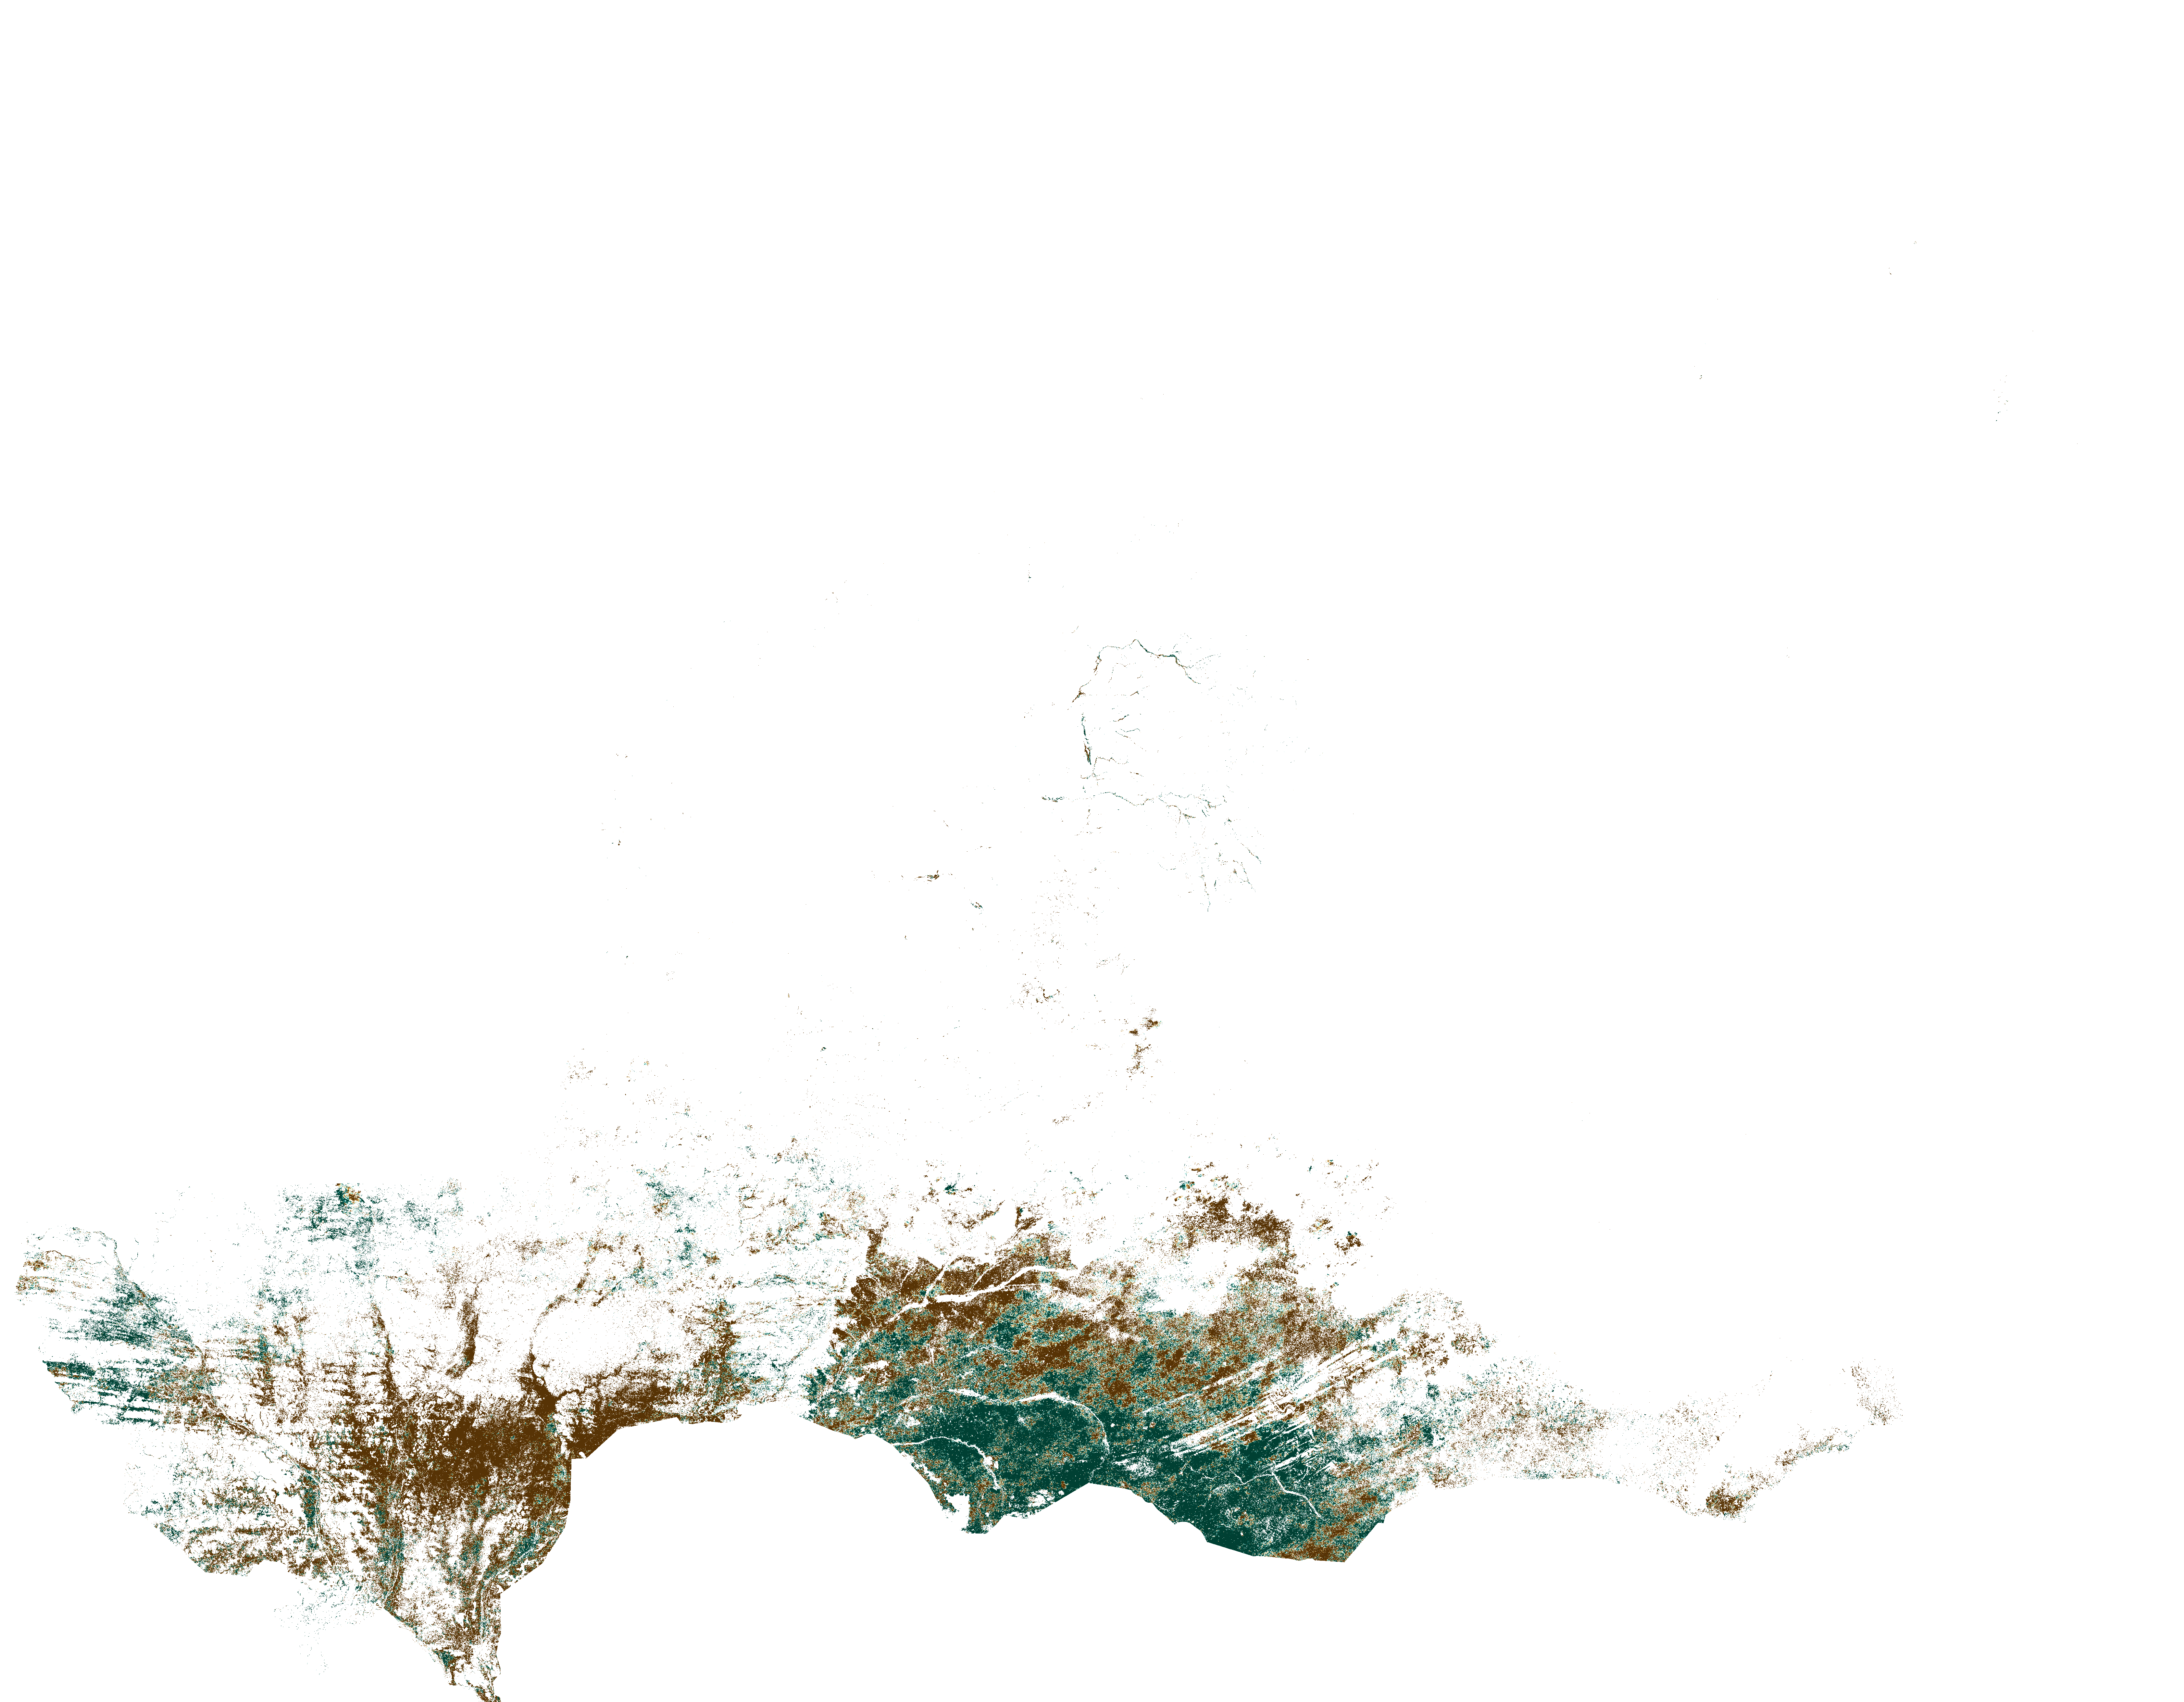

In [62]:
import folium as flm
from os.path import join, expanduser
import numpy as np
import leafmap.foliumap as leafmap
import rasterio as rio
zscore = join(expanduser('~'), 'Downloads', 'zcore_dea_2023_09.tif')
src = rio.open(zscore)

from rasterio import features
from shapely.geometry import box
from affine import Affine
from matplotlib import cm
from rasterio import warp

# gdf = gpd.read_file('../../data/shapefiles/ner_adm_ignn_20230720_ab_shp/NER_admbnda_adm1_IGNN_20230720.shp')
# gdf = gdf.to_crs(src.crs)
# gdf = gdf.loc[gdf.ADM1_FR=="Dosso"].copy()

# geometry = box(*gdf.total_bounds) # row.geometry.bounds
# window = features.geometry_window(src, [geometry])
# ul_y = window.col_off
# lr_x = window.row_off
# t = src.transform
# shifted_affine = Affine(t.a, t.b, t.c+ul_y*t.a, t.d, t.e, t.f+lr_x*t.e)
# data = src.read(1, window=window) # , masked=True

data = src.read(1)
# data[np.isnan(data)] = 0
# remask_image = leafmap.array_to_image(data, source=zscore)

left, bottom, right, top = src.bounds
# left, bottom, right, top = geometry.bounds
dest_crs = 'EPSG:4326'
left, bottom, right, top = warp.transform_bounds(src_crs=src.crs, dst_crs=dest_crs, left=left, 
                               bottom=bottom, right=right, top=top)
bounds = [[bottom, left], [top, right]]

# map it out!
# m = flm.Map([centy, centx], zoom_start=6)
# flm.raster_layers.ImageOverlay(
#     image=data,
#     name='sample map',
#     opacity=1,
#     bounds=bounds,
#     interactive=False,
#     cross_origin=False,
#     zindex=1,
#     colormap=cm.get_cmap('BrBG', 10)
# ).add_to(m)
# flm.LayerControl().add_to(m)
# m

# bounds = [[bottom, left], [top, right]]


m = leafmap.Map()
# # m.add_basemap('Esri.WorldImagery')
# # m.add_raster(remask_image, palette='BrBG', nodata=0, vmin=-3, vmax=3, layer_name='Z-Score Anomaly (2023-09)')
# # m.add_raster(zscore, palette='BrBG', nodata=np.nan, vmin=-3, vmax=3, layer_name='Z-Score Anomaly (2023-09)')
# img = flm.raster_layers.ImageOverlay(
#     data, 
#     bounds=bounds, 
#     name='EVI Z-Score',
#     colormap=cm.BrBG,
#     )
# img.add_to(m)

flm.raster_layers.ImageOverlay(
    image=data,
    name='sample map',
    opacity=1,
    bounds=bounds,
    interactive=False,
    cross_origin=False,
    zindex=1,
    colormap=cm.get_cmap('BrBG', 10)
).add_to(m)

m.set_center(lon=centx, lat=centy, zoom=6)
m.add_layer_control()
# flm.LayerControl().add_to(m)
m

In [5]:
# from os.path import join, expanduser
# import numpy as np
# import leafmap.foliumap as leafmap
# import rasterio as rio
# zscore = join(expanduser('~'), 'Downloads', 'zcore_dea_2023_09.tif')

# # src = rio.open(zscore)
# # data = src.read(1)
# # data[np.isnan(data)] = 0
# # remask_image = leafmap.array_to_image(data, source=zscore)

# # Viz
# pal = colormaps.get_palette('BrBG', 10) # Greens BrBG
# zscore_vis = {
#     'min': -3,
#     'max': 3,
#     'palette': pal
# }
# evi_vis = {
#     'min': 0.1,
#     'max': 0.4,
#     'palette': pal
# }
# adm_vis = {
#     'color': '000000',
#     'width': 1,
#     'opacity': 0.25
# }

# m = leafmap.Map()
# m.add_basemap('Esri.WorldImagery')
# # m.add_raster(remask_image, palette='BrBG', nodata=0, vmin=-3, vmax=3, layer_name='Z-Score Anomaly (2023-09)')
# m.add_raster(zscore, palette='BrBG', nodata=np.nan, vmin=-3, vmax=3, layer_name='Z-Score Anomaly (2023-09)')
# m.set_center(lon=centx, lat=centy, zoom=6)
# m.add_layer_control()
# m

### Aggregate Shares by Productivity

We run the same analysis for the previous 5 seasons, and aggregate the number of pixels according to different z-score buckets. The range of -0.5 to 0.5 signifies normal or average conditions. The shares above 0.5 signify greater than average conditions, whereas less than 0.5 signify worse conditions.

Overall there is a positive trend in agricultural conditions relative to the past ten years. In 2023 most areas fall under positive anomalies, 2022 had more areas in favorable conditions.

![chart1](./charts/evi-anomalies-pct.jpeg)

### Median Agricultural Productivity by Province

In the plot below, we aggregate the median EVI value for each region and compare that with the historical average (gray dotted line). Most provinces show productivity trends close or slightly above the baseline for 2023, except for Diffa and Dosso where the median trend is below the baseline.

![chart2](./charts/evi-median-region.jpeg)

## Crop Classification
With the objective of creating crop extent maps for different years, we ran a classification model using the EVI time series and crop seasonality parameters (250 meter resolution). We trained the model by selecting data for crop polygons from [Digital Earth Africa](https://docs.digitalearthafrica.org/en/latest/data_specs/Cropland_extent_specs.html#Training-and-Validation-data), resulting in a training dataset of ~500 areas and 18 features (EVI-derived crop season parameters).   

We used a Random Forest Classifier and validated the method on a test dataset (20% of training data not used in the model). Although the method was able to identify crops from the test dataset, the R-squared was quite low meaning the model is not fit for general use yet. 

**Accuracy of the Model**:  0.809  
**R-Squared**:  0.227  

See more details in [notebook](evi-classification.ipynb).

## Outlook for 2024
Despite the favorable vegetation conditions in 2023, food security agencies are projecting large food security shocks across Niger in 2024. The key factors are increasing food prices and market disruptions due to insecurity and sociopolitical factors. An in-depth analysis can be found from the [FEWS NET Food Security Outlook Februrary 2024](https://fews.net/west-africa/niger/food-security-outlook/february-2024)

### Food Security IPC Classification 
Source: FEWS NET

![Niger_2024-02-01_ML1.png](./charts/Niger_2024-04-01_ML1.png)